In [23]:
import librosa
import glob
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow
from time import time
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier



#load utils.py

In [24]:
def get_filenames():
    if not path.exists("speechcommands"):
        !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
        !mkdir speechcommands
        !tar -xf speech_commands_v0.01.tar.gz -C speechcommands
    
    # generamos lista con las rutas y nombres de archivo de los digitos
    numbers_filenames = []

    to_number =	{
      "zero": 0,
      "one": 1,
      "two": 2,
      "three": 3,
      "four": 4,
      "five": 5,
      "six": 6,
      "seven": 7,
      "eight": 8,
      "nine": 9
    }

    for i in to_number:
        path = 'speechcommands/' + i + '/*.wav'
        numbers_filenames.append(glob.glob(path))

    # guardamos la lista de los conjuntos de test y validación
    # solo para archivos que referencian a dígitos
    test_filenames = ['speechcommands/' + e for e in open('speechcommands/testing_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    valid_filenames = ['speechcommands/' + e for e in open('speechcommands/validation_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    train_filenames = [e for n in range(10) for e in numbers_filenames[n] if (e not in test_filenames) and (e not in valid_filenames)]

    print('train_count:' , len(train_filenames))
    print('test_count:' , len(test_filenames))
    print('valid_count:' , len(valid_filenames))
    
    return 	{
      "train_features.csv": train_filenames,
      "test_features.csv": test_filenames,
      "valid_features.csv": valid_filenames
    }
    

In [25]:
def count_elapsed_time(f):
    """
    Decorator.
    Execute the function and calculate the elapsed time.
    Print the result to the standard output.
    """
    def wrapper(*args, **kwargs):
        # Start counting.
        start_time = time()
        # Take the original function's return value.
        ret = f(*args, **kwargs)
        # Calculate the elapsed time.
        elapsed_time = time() - start_time
        print("Elapsed time: %0.10f seconds." % elapsed_time)
        return ret

    return wrapper

In [26]:
def calculate_features(filename, n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std], summary_names=['mean', 'std']):  
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)

  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])

  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
    
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
  
  summary_features = np.append(summary_features, [to_number[filename.split('/')[1]], filename])

  return summary_features

In [27]:
def name_features(filename = '', n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std], summary_names=['mean', 'std']):
    feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
    if energy: feat_names = feat_names + ['energy']
    feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
    if delta: d_names = ['d{}'.format(name) for name in feat_names]
    if deltadelta: dd_names = ['dd{}'.format(name) for name in feat_names]

    feat_names = feat_names + d_names + dd_names + ['digit', 'file']

    return feat_names

In [28]:
from os import path
@count_elapsed_time
def calculate_features_if_needed(result_filename):
    result_path = "features/"+result_filename
    result = []
    if not path.exists(result_path):
        print("Getting filenames")
        filenames_complete = get_filenames()
        filenames = filenames_complete[result_filename]        
        
        print("Calculating features for ", len(filenames), " rows -> ", result_path)
        features_names = name_features()
        features_data = [calculate_features(x) for x in filenames]
        pd.DataFrame(data = features_data, columns = features_names).to_csv(result_path)
    
    else:
        print("Loading saved features <- ", result_path)
        result = pd.read_csv(result_path)
    
    return result

##  Obtenemos features  y eliminamos las columnas innecesarias para la predicción

In [29]:
import os.path
from os import path

if not path.exists("features/test_features.csv"):
    !wget https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/test_features.csv -P features
    
if not path.exists("features/train_features.csv"):        
    !wget https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/train_features.csv -P features
        
if not path.exists("features/valid_features.csv"):        
    !wget https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/valid_features.csv -P features


In [30]:
%%time
# Variables a excluir de la predicción
var_exclude = ['file', 'Unnamed: 0']

test_features = pd.DataFrame(calculate_features_if_needed("test_features.csv"))
test_features.drop(var_exclude, axis=1, inplace=True)
test_features.head(10)
pd.crosstab(index=test_features["digit"], columns="count", normalize=True)

Loading saved features <-  features/test_features.csv
Elapsed time: 0.0479600430 seconds.
CPU times: user 51.9 ms, sys: 8.01 ms, total: 59.9 ms
Wall time: 57.6 ms


col_0,count
digit,
0,0.097962
1,0.097179
2,0.103448
3,0.104624
4,0.099138
5,0.106191
6,0.095611
7,0.093652
8,0.100705


In [13]:
%%time
validation_features = pd.DataFrame(calculate_features_if_needed("valid_features.csv"))
validation_features.head(10)

validation_features.drop(var_exclude, axis=1, inplace=True)
validation_features.head(10)
pd.crosstab(index=validation_features["digit"], columns="count", normalize=True)

Loading saved features <-  features/valid_features.csv
Elapsed time: 0.0618190765 seconds.


col_0,count
digit,
0,0.104250
1,0.092221
2,0.094627
3,0.099439
4,0.112269
5,0.097033
6,0.105052
7,0.105453
8,0.097434


In [22]:
%%time
train_features = pd.DataFrame(calculate_features_if_needed("train_features.csv"))
train_features.head(10)
train_features.drop(var_exclude, axis=1, inplace=True)
train_features.head(10)
pd.crosstab(index=train_features["digit"], columns="count", normalize=True)

Loading saved features <-  features/train_features.csv
Elapsed time: 0.2334725857 seconds.
CPU times: user 231 ms, sys: 20 ms, total: 251 ms
Wall time: 248 ms


col_0,count
digit,
0,0.100215
1,0.101611
2,0.100591
3,0.098872
4,0.098765
5,0.099033
6,0.100054
7,0.100698
8,0.099463


# Modelos

## Naive Bayes

In [15]:
%%time
## Naive Bayes Modelo 1 -- Sin hiperparametros
naive_bayes_1 = GaussianNB()
naive_bayes_1.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
predict_nb1 = naive_bayes_1.predict(validation_features.drop('digit',axis=1).values)

print("Accuracy training : {:.3f}".format(naive_bayes_1.score(train_features.drop('digit',axis=1).values, 
                                                               train_features.digit.values)))
print("Accuracy Validación: {:.3f}".format(naive_bayes_1.score(validation_features.drop('digit',axis=1).values, 
                                                          validation_features.digit.values)))

print(classification_report(validation_features.digit.values, predict_nb1))

Accuracy training : 0.541
Accuracy Validación: 0.537
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       260
           1       0.36      0.58      0.45       230
           2       0.37      0.48      0.42       236
           3       0.55      0.55      0.55       248
           4       0.72      0.53      0.61       280
           5       0.54      0.53      0.54       242
           6       0.50      0.58      0.54       262
           7       0.58      0.49      0.53       263
           8       0.74      0.56      0.63       243
           9       0.61      0.41      0.49       230

    accuracy                           0.54      2494
   macro avg       0.56      0.54      0.54      2494
weighted avg       0.57      0.54      0.54      2494



Text(19.5, 0.5, 'True')

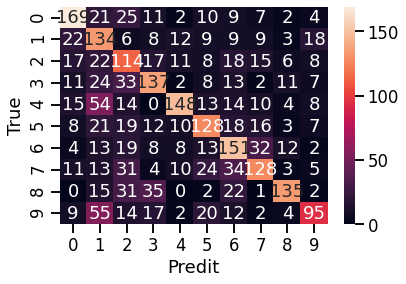

In [16]:
%%time
## Matriz de Confusión 
sns.set_context('talk')
sns.heatmap(confusion_matrix(validation_features.digit.values, predict_nb1), annot=True, fmt='g')
#sns.set(font_scale=0.2) 
plt.xlabel('Predit')
plt.ylabel('True')

## Random Forest [Sin Hiperparámetros]

In [17]:
%%time
random_forest1 = RandomForestClassifier(n_estimators=450, max_depth=10, bootstrap=False,  random_state=1)
#random_forest1 = RandomForestClassifier(random_state=1)
random_forest1.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
predict_rf1 = random_forest1.predict(validation_features.drop('digit',axis=1).values)

print("Accuracy training : {:.3f}".format(random_forest1.score(train_features.drop('digit',axis=1).values, 
                                                               train_features.digit.values)))
print("Accuracy Validación: {:.3f}".format(random_forest1.score(validation_features.drop('digit',axis=1).values, 
                                                          validation_features.digit.values)))

print(classification_report(validation_features.digit.values, predict_rf1))

Accuracy training : 0.896
Accuracy Validación: 0.670
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       260
           1       0.54      0.61      0.57       230
           2       0.62      0.54      0.58       236
           3       0.60      0.67      0.63       248
           4       0.66      0.75      0.70       280
           5       0.73      0.57      0.64       242
           6       0.82      0.70      0.76       262
           7       0.68      0.65      0.67       263
           8       0.76      0.81      0.78       243
           9       0.67      0.60      0.63       230

    accuracy                           0.67      2494
   macro avg       0.67      0.67      0.67      2494
weighted avg       0.68      0.67      0.67      2494



## Probamos Hiperparámetros

In [18]:
## Primero unir train & validación (Esto según lo que preguntaron en el documento pero aún no lo tengo claro)
to_hiper = train_features.append(validation_features, ignore_index=True)

#genero listo con datos a usar en split de validación u entrenamiento -1 para entrenar y 0 para validar
test_fold = list([-1] * len(train_features) + [0]*len(validation_features))

In [19]:
%%time
### Agrego hiperparametrización 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit

kfoldcv = PredefinedSplit(test_fold)  ## Indices de Split predefinido de Validacion

parametros = {'n_estimators':range(100, 250, 15), 'max_depth':range(6, 12, 2), 'bootstrap':[True, False], 'random_state': range(0, 5, 1)}


clf = RandomizedSearchCV(RandomForestClassifier(), parametros, n_jobs=10, random_state=131313,    
                         scoring='accuracy', n_iter=3, cv = kfoldcv)

### Me genera muchas dudas la data con la que se fitea xq no deberían ser entrenamiento y validación
## con esto se está haciendo trampa
clf.fit(to_hiper.drop('digit',axis=1).values, to_hiper.digit.values)
rf = clf.best_estimator_  

print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(rf.score(train_features.drop('digit',axis=1).values, 
                                                   train_features.digit.values)))
print("Accuracy Validación: {:.3f}".format(rf.score(validation_features.drop('digit',axis=1).values, 
                                                          validation_features.digit.values)))

0.6672012830793905 {'random_state': 4, 'n_estimators': 175, 'max_depth': 10, 'bootstrap': False}
Accuracy training : 0.881
Accuracy Validación: 0.862


In [29]:
%%time
rf_mejor = RandomForestClassifier(random_state=4, n_estimators=175, max_depth=10, bootstrap=False)
rf_mejor.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)

print("Accuracy training : {:.3f}".format(rf.score(train_features.drop('digit',axis=1).values, 
                                                   train_features.digit.values)))
print("Accuracy Validación: {:.3f}".format(rf.score(validation_features.drop('digit',axis=1).values, 
                                                          validation_features.digit.values)))

Accuracy training : 0.881
Accuracy Validación: 0.862


## Gradient Boosting

In [20]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

parameters = {'n_estimators':range(50, 150, 25), 'max_depth':range(5,7), 'learning_rate':np.arange(0,1,0.1)}
clf = RandomizedSearchCV(GradientBoostingClassifier(), parameters, n_jobs=10, scoring='accuracy',cv=kfoldcv, n_iter=50, random_state=8)

clf.fit(to_hiper.drop('digit',axis=1).values, to_hiper.digit.values)
gb = clf.best_estimator_

print (clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(gb.score(train_features.drop('digit',axis=1).values, 
                                                   train_features.digit.values))) 
print("Accuracy test: {:.3f}".format(gb.score(validation_features.drop('digit',axis=1).values, 
                                                   validation_features.digit.values)))

0.7522052927024859 {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.30000000000000004}


AttributeError: 'DataFrame' object has no attribute 'digitnumber'

In [ ]:
%%time
gb_mejor = RandomForestClassifier(random_state=73, n_estimators=, max_depth=, learning_rate=)
gb_mejor.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)

print("Accuracy training : {:.3f}".format(gb_mejor.score(train_features.drop('digit',axis=1).values, 
                                                   train_features.digit.values)))
print("Accuracy Validación: {:.3f}".format(gb_mejor.score(validation_features.drop('digit',axis=1).values, 
                                                          validation_features.digit.values)))

In [ ]:
%%time
## Matriz de Confusión 
gb_pred = gb_mejor.predict(validation_features.drop('digit',axis=1).values)
sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, gb_pred), annot=True, fmt='g')
#sns.set(font_scale=0.2) 
plt.xlabel('Predit')
plt.ylabel('True')